In [1]:
#!pip uninstall numpy

In [1]:
import pandas

In [2]:
#!pip install pysimplegui

import PySimpleGUI as sg
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pyabf 
import sys
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import statistics
# import matplotx




In [3]:
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
import openpyxl

In [74]:
# #open file with GUI write
# my_file = pyabf.ABF("2023_07_10_0000.abf")
# print (my_file.sweepList)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [4]:
# GUI to choose file
tres = 0
my_file = False
while True:
    event, values = sg.Window('Get filename example', [[sg.Text('Filename')], [sg.Input(), sg.FileBrowse()], [sg.OK(), sg.Cancel()] ]).read(close=True)
    if event == 'Cancel':
        break
    try:
        my_file = pyabf.ABF(values[0])
        break
    except:
        print('Incorrect file format')

In [5]:
#print(my_file) pprint(my_file.dict) pprint(my_file.dataRate)

# how many sweeps
print("Number of sweeps ", my_file.sweepList) 
print("Sampling rate ", my_file.dataRate)

sample_rate = int(my_file.dataRate)

#needs for correct plotting 

if sample_rate == 20000:
    # Time for PreStim and Stim for Channel 0
    start10 = 0 
    end10 = 2800    
    start11 = 6000 
    end11 = 12800 
    # Time for PreStim and Stim for Channel 2
    start20 = 28000 
    end20 = 30800 
    start21 = 34000 
    end21 = 40800 
    # Rin calculation
    Rtime_ch0 = 8000 
    Rtime_ch2 = 36000 
elif sample_rate == 10000:
    # Time for PreStim and Stim for Channel 0
    start10 = 0 
    end10 = 1400     
    start11 = 3000 
    end11 = 6400 
    # Time for PreStim and Stim for Channel 2
    start20 = 14000
    end20 = 15400
    start21 = 16600
    end21 = 20000 
    # Rin calculation
    Rtime_ch0 = 4000
    Rtime_ch2 = 18000 
else:
    print("Check the Sampling rate!")

Number of sweeps  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Sampling rate  10000


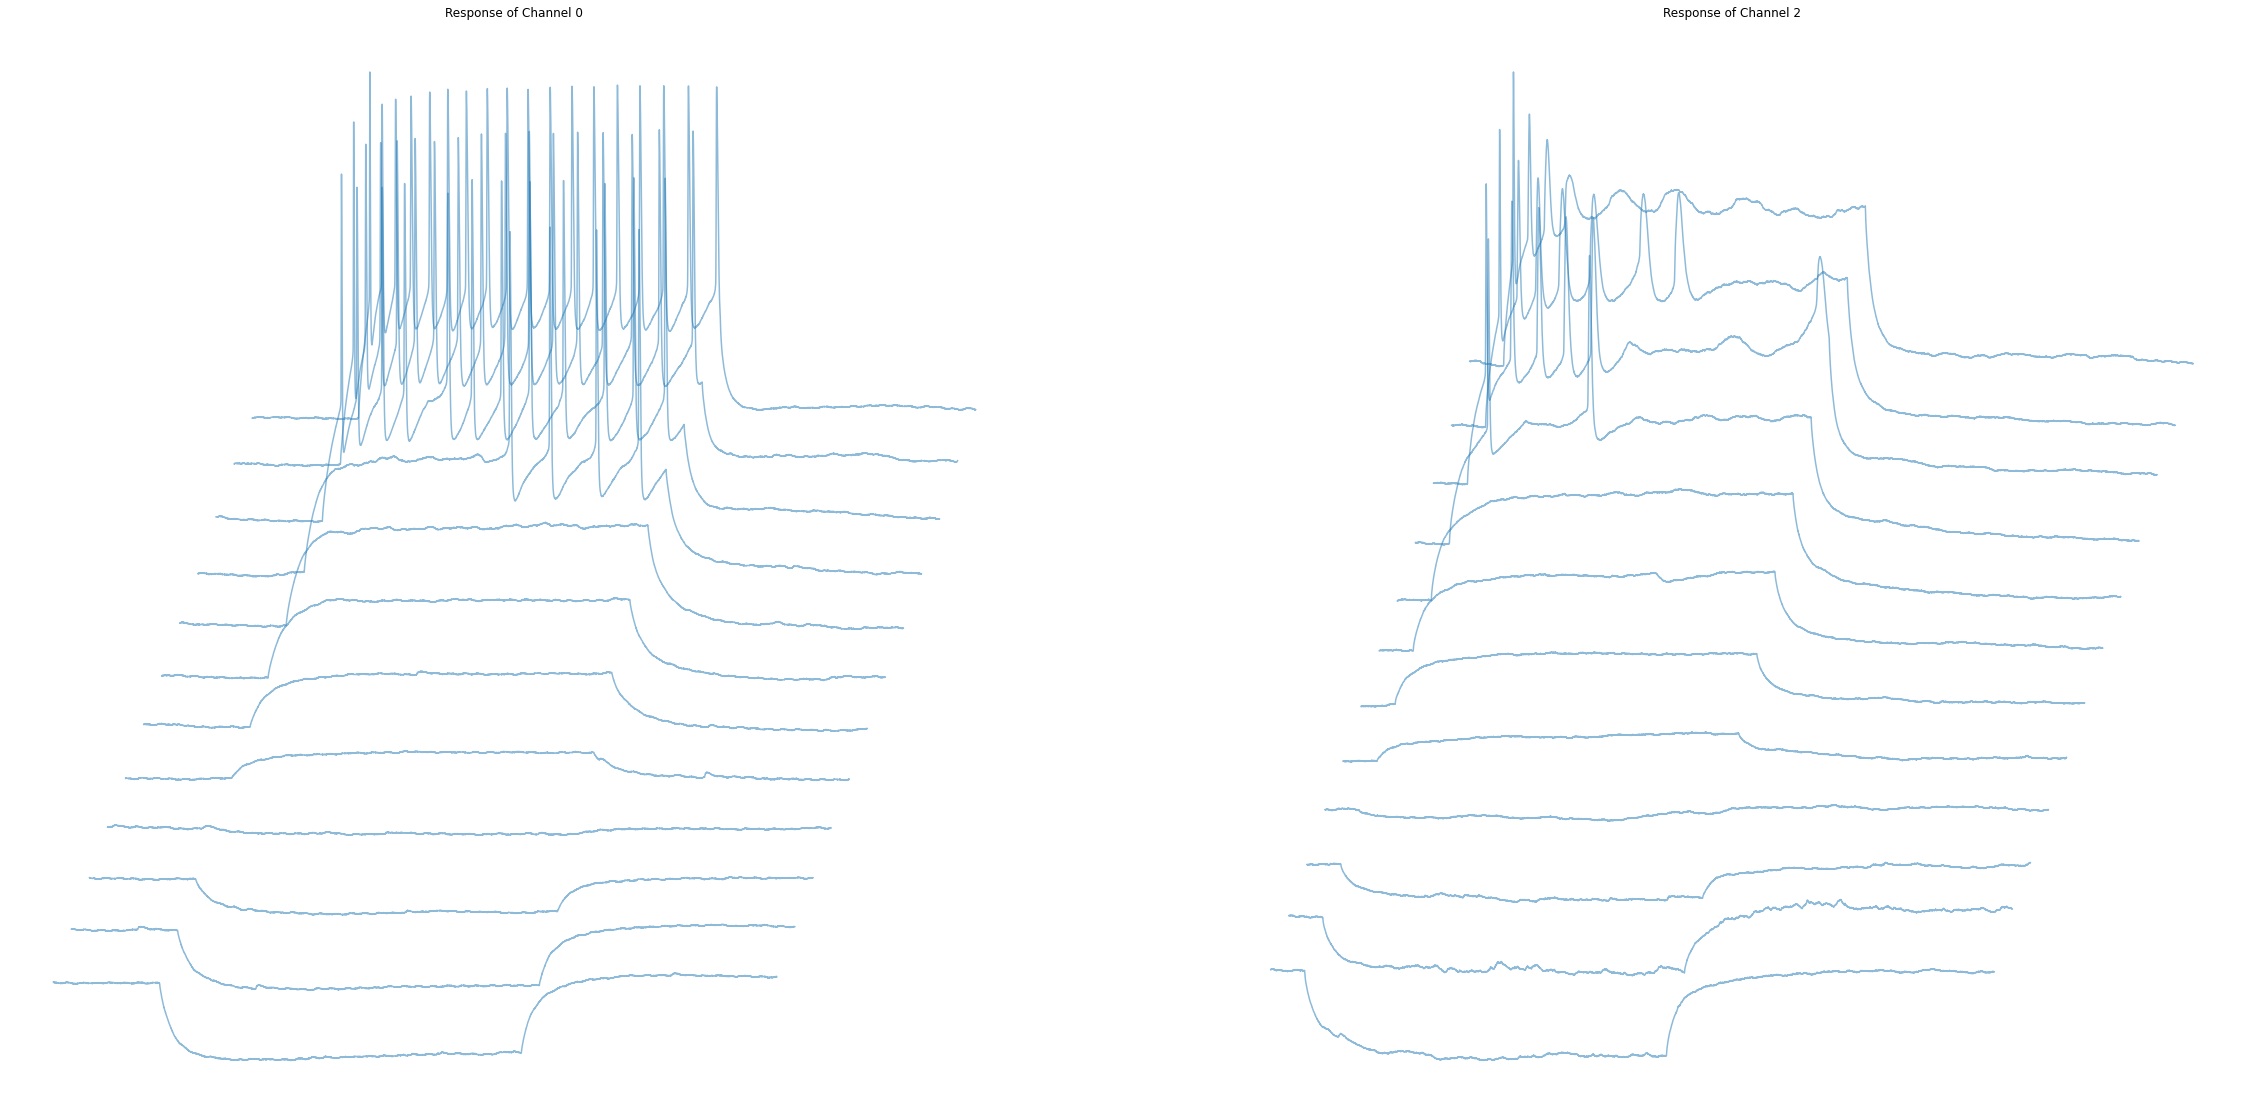

In [6]:
# Response of both cells plots

plt.figure(figsize=(40,20))

plt.subplot (1,2,1)

for my_sweepNumber in my_file.sweepList:
    my_file.setSweep(sweepNumber = my_sweepNumber, channel = 0)
    i1, i2 = 0, int(my_file.dataRate * 1)  # plot part of the sweep
    dataX = my_file.sweepX[i1:i2] + .025 * my_sweepNumber
    dataY = my_file.sweepY[i1:i2] + 15 * my_sweepNumber
    plt.plot(dataX, dataY, color='C0', alpha=.5, label=my_sweepNumber)
# matplotx.line_labels()
plt.gca().axis('off')  # hide axes to enhance floating effect
plt.title("Response of Channel 0")

plt.subplot (1,2,2)

for my_sweepNumber in my_file.sweepList:
    my_file.setSweep(sweepNumber = my_sweepNumber, channel = 2)
    i1, i2 = 15000, int(my_file.dataRate * 2.5)  # plot part of the sweep #15000 in original for 10kHz sampling
    dataX = my_file.sweepX[i1:i2] + .025 * my_sweepNumber
    dataY = my_file.sweepY[i1:i2] + 15 * my_sweepNumber
    plt.plot(dataX, dataY, color='C0', alpha=.5, label=my_sweepNumber)
# matplotx.line_labels()
plt.gca().axis('off')  # hide axes to enhance floating effect
plt.title("Response of Channel 2")


plt.show()

In [7]:
# Choose channel for analysis 

my_search_ch = int(input("Please enter your #channel (0 or 2!) "))

Please enter your #channel (0 or 2!) 0


In [43]:
freq = 1/my_file.dataRate
num_points = 40 #number of points for smoothing

def channel (file, search_ch):
    if search_ch == 0:
        start = int(0.14*file.dataRate)
        stop = int(0.7*file.dataRate)
    if search_ch == 2:
        start = int(1.54*file.dataRate)
        stop = int(2.1*file.dataRate)
    return start, stop

def sweep_3Aps (file, search_ch, start, stop):
    #choose the sweep with at least 3 spikes
    for sweep_num in range(len(file.sweepList)):
        file.setSweep(sweep_num, channel = search_ch)
        peaks = find_peaks(file.sweepY[start:stop], height=-10)
        print(peaks, 'My peaks')
        if len(peaks[0])>=4:
            sweep = sweep_num #sweep is detected
            break
        elif len(peaks[0])<4 and sweep_num==len(file.sweepList):
            print('Sweep is not detected!')
    print(sweep)
    return sweep


#inflection points detection
def infl_points (file, sweep, search_ch, start, stop, num_pts):
        file.setSweep(sweep, channel = search_ch)
        smooth = gaussian_filter1d(file.sweepY[start:stop], num_pts) # smooth
        smooth_d2 = np.gradient(np.gradient(smooth)) # compute second derivative
        infls = np.where(np.diff(np.sign(smooth_d2)))[0]# find switching points
        ind_infls = infls + start
        return ind_infls


#find indexes of peaks
def peak (file, start, stop, v_level= -10):
    peaks= find_peaks(file.sweepY[start:stop], height=v_level, distance=10)
    ind_peaks = peaks[0] + start
    return ind_peaks


def spike_begin (ind_peaks, ind_infls):
    #find the beginning of spike (the index before the peak index)
    start_ap_ind_list = [j for i in range (len(ind_peaks)) for j in range (len(ind_infls)) if ind_peaks[i]>ind_infls[j] and ind_peaks[i]<ind_infls[j+1]]
    start_ap_ind = ind_infls[start_ap_ind_list]
    #find the "end" of spike (the index after the peak index) - needs only for the FWHM calculation
    end_ap_ind_list = [j for i in range (len(ind_peaks)) for j in range (len(ind_infls)) if ind_peaks[i]<ind_infls[j] and ind_peaks[i]>ind_infls[j-1]]
    end_ap_ind = ind_infls[end_ap_ind_list]
    return start_ap_ind, end_ap_ind


#Parameters calculation
#Amplitude ratio (2nd and 1st spike)

my_start, my_stop = channel(my_file, my_search_ch)
my_sweep = sweep_3Aps(my_file, my_search_ch, my_start, my_stop)
my_ind_infls = infl_points (my_file, my_sweep, my_search_ch, my_start, my_stop, num_points)
voltage_level = np.mean(my_file.sweepY[my_ind_infls])
#print(voltage_level)
my_ind_peaks = peak (my_file, my_start, my_stop)
print (len(my_ind_peaks), 'check peak')

my_start_ap_ind = spike_begin(my_ind_peaks, my_ind_infls)[0]
my_end_ap_ind = spike_begin(my_ind_peaks, my_ind_infls)[1]



ap1_ampl = my_file.sweepY[my_ind_peaks[0]] - my_file.sweepY[my_start_ap_ind[0]] #mV
ap2_ampl = my_file.sweepY[my_ind_peaks[1]] - my_file.sweepY[my_start_ap_ind[1]] #mV
ap_ampl_ratio = np.round(ap2_ampl/ap1_ampl, 2)

# amplitudes of spikes
#ampl_list = [my_file.sweepY[ind_peaks[i]] - my_file.sweepY[start_ap_ind[i]] for i in range (len(ind_peaks))]
#print(ampl_list)

#Initial firing frequency
in_freq = np.round(1/((my_ind_peaks[1]-my_ind_peaks[0])*freq),2) #Hz

#Late firing frequency       
late_freq = np.round(1/((my_ind_peaks[-1]-my_ind_peaks[-2])*freq),2) #Hz
print(late_freq, 'Check')
print(my_ind_peaks[-1], 'Check')
print(my_ind_peaks[-2], 'Check')

#Mean firing frequency
freq_list = [1/((my_ind_peaks[i+1]-my_ind_peaks[i])*freq) for i in range (-(len(my_ind_peaks)-1),-1)]
mean_freq = np.round(statistics.mean(freq_list), 2)#Hz

print(len(my_ind_peaks), 'Check 2')


#calculation based on extraction of the peak from the pre- and post- inflection point of the spike
print(my_ind_peaks)
my_fwhm_full = scipy.signal.peak_widths(my_file.sweepY[my_start_ap_ind[0]:my_end_ap_ind[0]], my_ind_peaks[:1]-my_start_ap_ind[0], 0.5)
print(my_fwhm_full)
my_fwhm = np.round(my_fwhm_full[0]*0.1,2) #width is diven in differenses between indexes
my_data_check = scipy.signal.peak_prominences(my_file.sweepY[my_start_ap_ind[0]:my_end_ap_ind[0]], my_ind_peaks[:1]-my_start_ap_ind[0])
print(my_data_check)

#time before the 1st spike 
if my_search_ch==0:
    start_imp = int(0.1468/freq)
    time_pre1ap = (my_start_ap_ind[0]-int(0.1468/freq))*freq
if my_search_ch==2:
    start_imp = int(1.5468/freq)
    time_pre1ap = (my_start_ap_ind[0]-int(1.5468/freq))*freq


print()
print(ap_ampl_ratio, 'no units')
print(in_freq, 'Hz')
print(late_freq, 'Hz')
print(mean_freq, 'Hz')
print(my_fwhm, 'ms')
print(time_pre1ap, 's')

(array([], dtype=int64), {'peak_heights': array([], dtype=float64)}) My peaks
(array([], dtype=int64), {'peak_heights': array([], dtype=float64)}) My peaks
(array([], dtype=int64), {'peak_heights': array([], dtype=float64)}) My peaks
(array([], dtype=int64), {'peak_heights': array([], dtype=float64)}) My peaks
(array([], dtype=int64), {'peak_heights': array([], dtype=float64)}) My peaks
(array([], dtype=int64), {'peak_heights': array([], dtype=float64)}) My peaks
(array([], dtype=int64), {'peak_heights': array([], dtype=float64)}) My peaks
(array([], dtype=int64), {'peak_heights': array([], dtype=float64)}) My peaks
(array([2912, 3465, 4109, 4697], dtype=int64), {'peak_heights': array([30.5786, 31.9214, 31.0974, 31.189 ])}) My peaks
8
4 check peak
17.01 Check
6097 Check
5509 Check
4 Check 2
[4312 4865 5509 6097]
(array([22.0557]), array([-1.5869]), array([35.7635]), array([57.8193]))
(array([64.3311]), array([0], dtype=int64), array([84], dtype=int64))

1.03 no units
18.08 Hz
17.01 Hz


In [34]:
#approximation to find exact position of FWHM

half_ampl = my_file.sweepY[my_start_ap_ind[0]]+ap1_ampl/2
print(half_ampl, 'half ampl')
search_up = my_file.sweepY[my_start_ap_ind[0]:my_ind_peaks[0]]
search_up_ind = []
search_down = my_file.sweepY[my_ind_peaks[0]:my_start_ap_ind[1]]
search_down_ind = []

find_up_ind = np.searchsorted(search_up, half_ampl)
#print(find_up_ind)
if my_file.sweepY[my_start_ap_ind[0]+find_up_ind]>=half_ampl:
    search_up_ind = [find_up_ind-1, find_up_ind]
if my_file.sweepY[my_start_ap_ind[0]+find_up_ind]<half_ampl:
    search_up_ind = [find_up_ind, find_up_ind+1]
    
print(search_up_ind, 'x indexes')
print(my_file.sweepY[search_up_ind+my_start_ap_ind[0]], 'Y values')

print(my_file.sweepX[search_up_ind+my_start_ap_ind[0]], 'time x for roots')
my_fit_up = np.polyfit(my_file.sweepX[search_up_ind+my_start_ap_ind[0]], my_file.sweepY[search_up_ind+my_start_ap_ind[0]], 1)
#print(my_fit)
up_p = [my_fit_up[0], my_fit_up[1]-half_ampl]
print(up_p)
my_root_up = np.roots(up_p)
print(my_root_up)


print()
print()

find_down_ind = np.searchsorted(-search_down, -half_ampl) #not the best way due to criteria for absending order 

#print(find_up_ind)
if my_file.sweepY[my_ind_peaks[0]+find_down_ind]>=half_ampl:
    search_down_ind = [find_down_ind, find_down_ind+1]
if my_file.sweepY[my_ind_peaks[0]+find_down_ind]<half_ampl:
    search_down_ind = [find_down_ind-1, find_down_ind]
    
print(search_down_ind, 'x indexes')
print(my_file.sweepY[search_down_ind+my_ind_peaks[0]], 'Y values')

print(my_file.sweepX[search_down_ind+my_ind_peaks[0]], 'time x for roots')
my_fit_down = np.polyfit(my_file.sweepX[search_down_ind+my_ind_peaks[0]], my_file.sweepY[search_down_ind+my_ind_peaks[0]], 1)
print(my_fit_down, 'coef') #coef
down_p = [my_fit_down[0], my_fit_down[1]-half_ampl]
print(down_p)
my_root_down = np.roots(down_p)
print(my_root_down)

print()
print(my_ind_peaks[0])
print(my_root_up+my_start_ap_ind[0]+search_up_ind[0])
print(my_root_down+my_ind_peaks[0]+search_down_ind[0])
my_half_total = ((my_root_down+my_ind_peaks[0]+search_down_ind[0])-(my_root_up+my_start_ap_ind[0]+search_up_ind[0]))*0.05
my_fwhm_approximated = np.round(my_half_total, 2)
my_half_total_correct = my_root_down-my_root_up
print()
print(my_half_total)
print(my_root_down-my_root_up)

-1.5869140625 half ampl
[35, 36] x indexes
[-9.7656  0.946 ] Y values
[0.4305 0.4306] time x for roots
[107116.69921856115, -46121.917724528044]
[0.4306]


[15, 16] x indexes
[ 0.4883 -2.0447] Y values
[0.4327 0.4328] time x for roots
[-25329.5898  10960.6018] coef
[-25329.589843737707, 10962.188720697803]
[0.4328]

4312
[4305.4306]
[4327.4328]

[1.1001]
[0.0022]


[1400, 7000]
[0.14   0.1401 0.1402 ... 0.6997 0.6998 0.6999]
[array([0.4306]), array([0.4328])]
[43.05763532763531, 43.27819277108433]


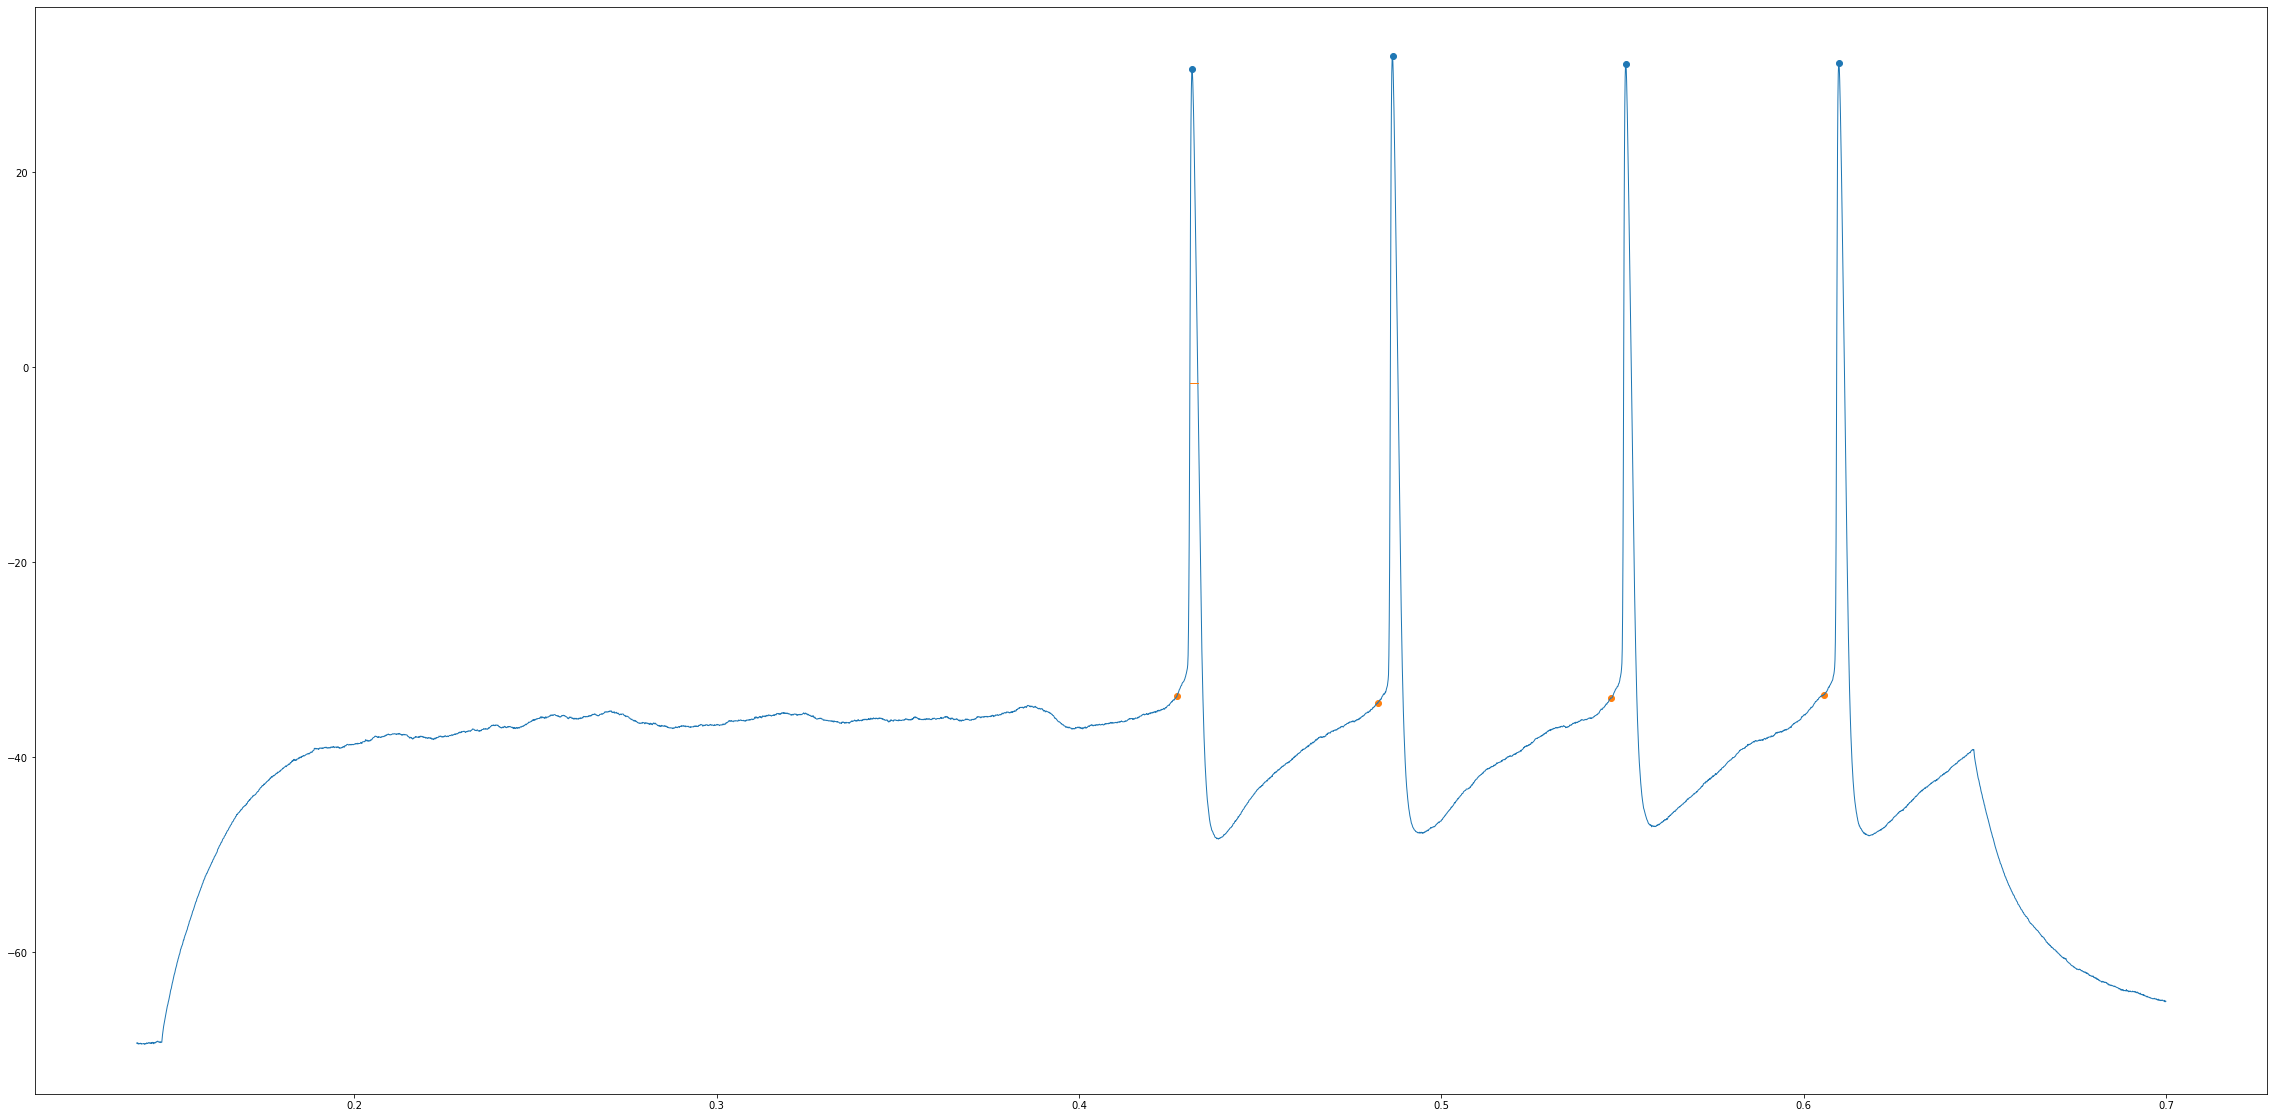

In [35]:
#Plot the AP peak and start and 1st spike FWHM

print([my_start, my_stop])
print(my_file.sweepX[my_start:my_stop])
print([my_root_up, my_root_down])
print([my_root_up[0]*100, my_root_down[0]*100])

plt.figure(figsize=(40,20))
#The main signal
plt.plot(my_file.sweepX[my_start:my_stop], my_file.sweepY[my_start:my_stop], label='Noisy Data', linewidth=1)
#Peaks
plt.scatter(my_file.sweepX[my_ind_peaks], my_file.sweepY[my_ind_peaks])
#Begining of the spike
plt.scatter(my_file.sweepX[my_start_ap_ind], my_file.sweepY[my_start_ap_ind])


#plt.scatter(my_file.sweepX[my_end_ap_ind[0]], my_file.sweepY[my_end_ap_ind[0]])
fwhm_Y_1 = my_root_up*my_fit_up[0]+my_fit_up[1]
fwhm_Y_2 = my_root_down*my_fit_down[0]+my_fit_down[1]
plt.plot([my_root_up[0], my_root_down[0]], [fwhm_Y_1, fwhm_Y_2],  linewidth=1)

# plt.scatter(my_file.sweepX[int(my_fwhm_full[2])+my_start_ap_ind[0]], my_file.sweepY[int(my_fwhm_full[2])+my_start_ap_ind[0]])
# plt.scatter(my_file.sweepX[int(my_fwhm_full[3])+my_start_ap_ind[0]], my_file.sweepY[int(my_fwhm_full[3])+my_start_ap_ind[0]])

# plt.scatter(my_file.sweepX[my_start_ap_ind[0]+search_up_ind], my_file.sweepY[my_start_ap_ind[0]+search_up_ind])
# plt.scatter(my_file.sweepX[my_ind_peaks[0]+search_down_ind], my_file.sweepY[my_ind_peaks[0]+search_down_ind])
#plt.plot(my_file.sweepX[my_start:my_stop], smooth, label='Smoothed Data')
#plt.plot(abf.sweepX[1400:7000], smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
#for i, infl in enumerate(infls, 1):
 #   plt.axvline((infl + start_ch0)*freq, color='k', label=f'Inflection Point {i}')
#plt.legend(bbox_to_anchor=(1.55, 1.0))

plt.savefig(r'C:\Users\user\Documents\IMBIT\Master\myyy_plot.jpg')

In [58]:
print(my_file.sweepX[my_start:my_stop])

[0.14   0.1401 0.1402 ... 0.6997 0.6998 0.6999]


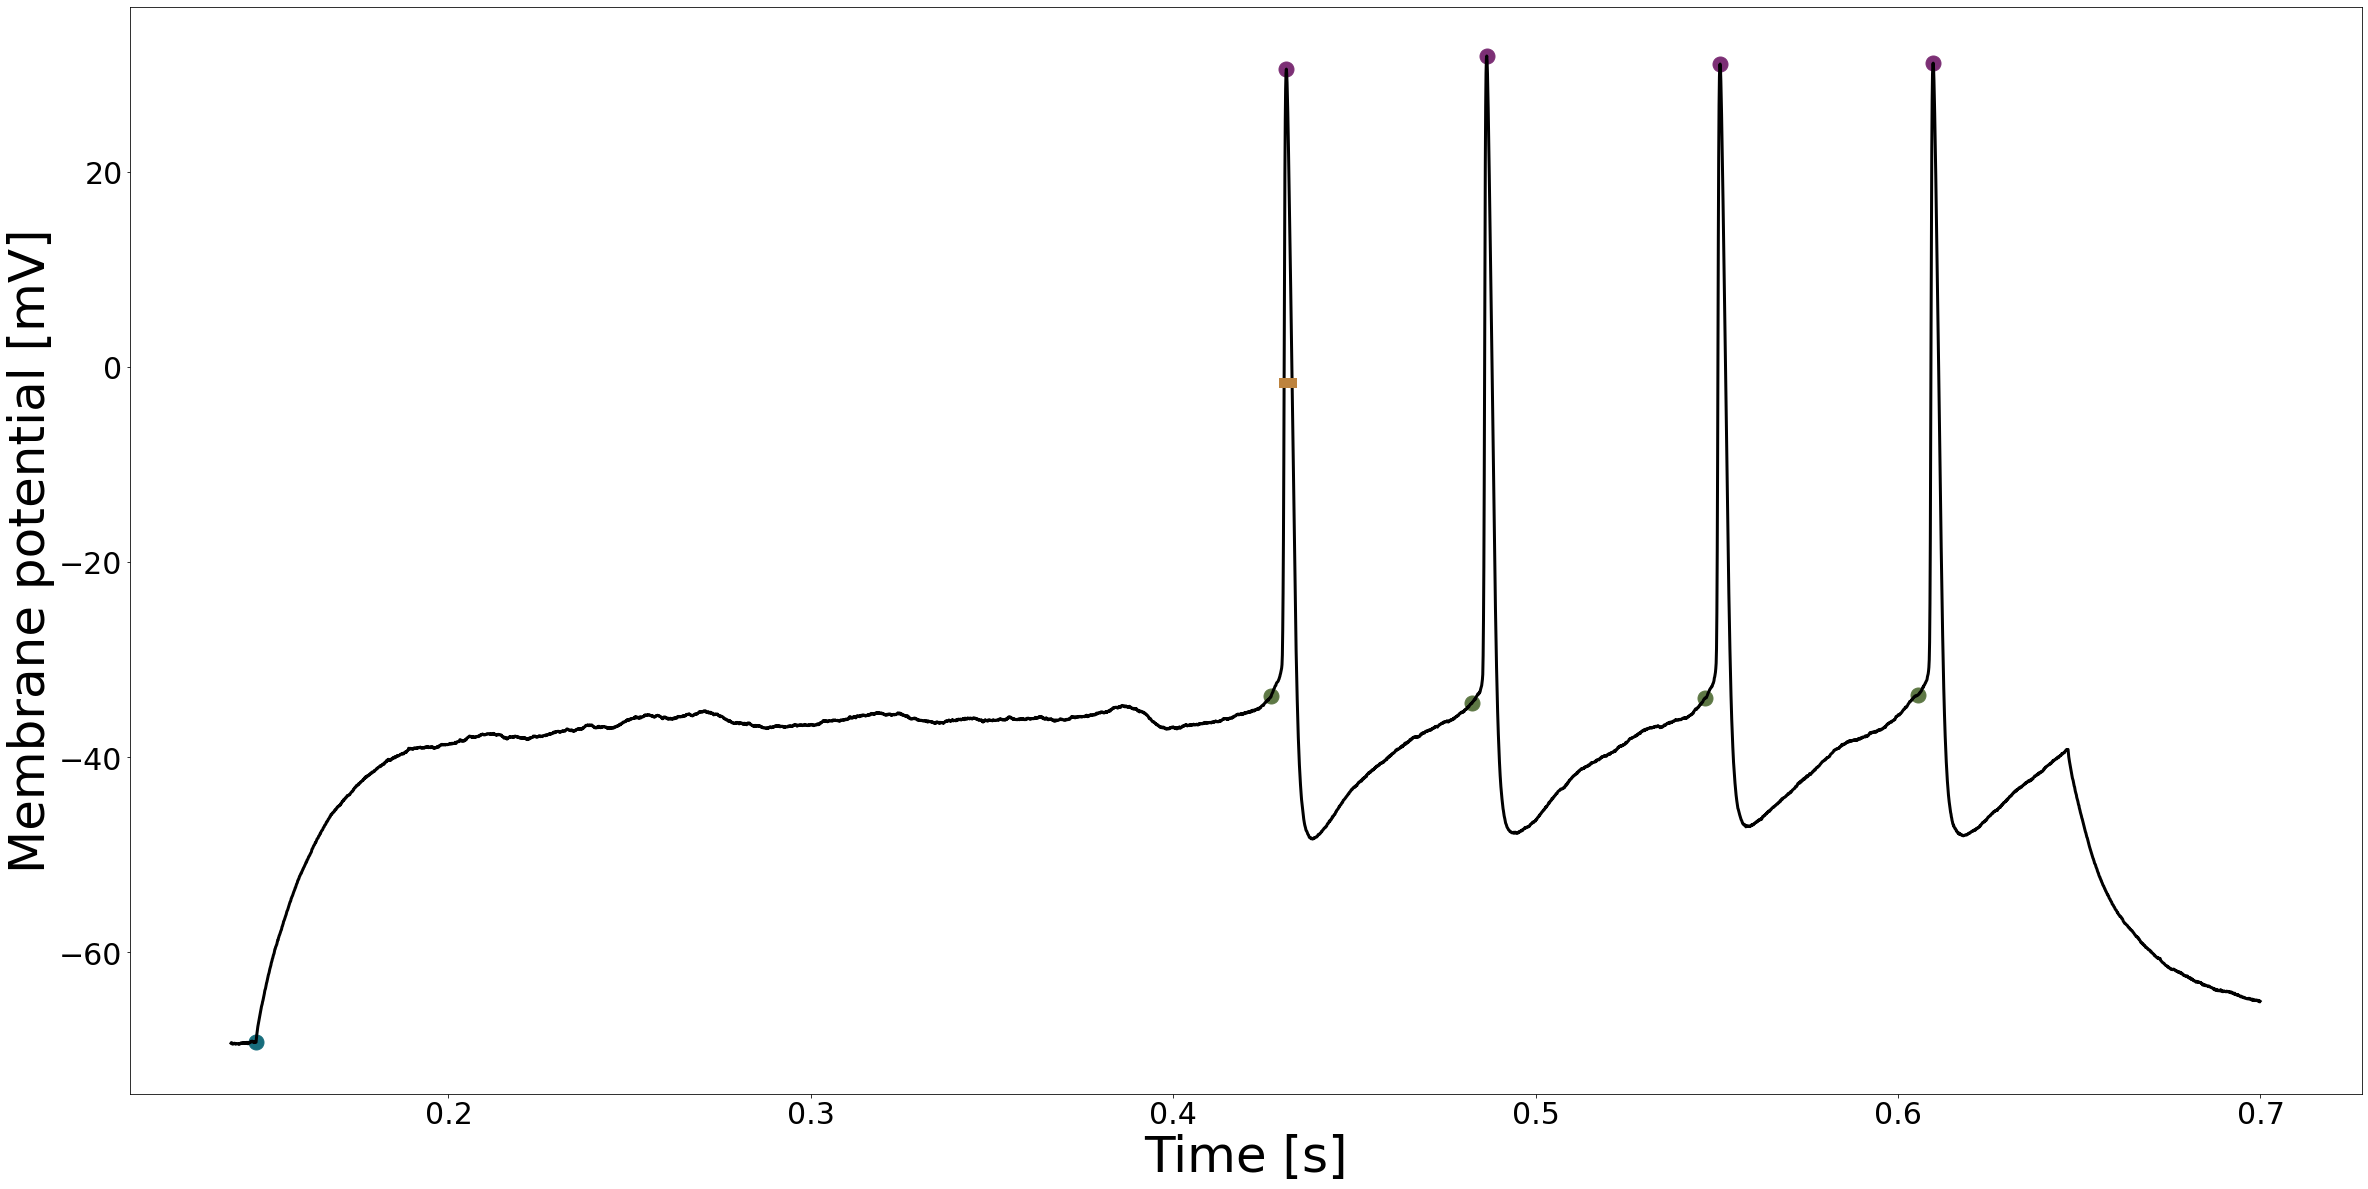

In [65]:
plt.figure(figsize=(40,20))
#The main signal

plt.plot(my_file.sweepX[my_start:my_stop], my_file.sweepY[my_start:my_stop], color = 'k', label='Noisy Data', linewidth=3)
plt.ylabel('Membrane potential [mV]', fontsize=50, loc='center')
plt.xlabel('Time [s]', fontsize=50)
plt.tick_params(axis='both', which='major', labelsize=30)
#Peaks
plt.scatter(my_file.sweepX[my_ind_peaks], my_file.sweepY[my_ind_peaks],s = 15**2, c = '#7C2F75')
#Begining of the spike
plt.scatter(my_file.sweepX[my_start_ap_ind], my_file.sweepY[my_start_ap_ind], s = 15**2, c = '#5E7845')
plt.scatter(my_file.sweepX[start_imp], my_file.sweepY[start_imp], s = 15**2, c = '#176D7C')
plt.plot([my_root_up[0], my_root_down[0]], [fwhm_Y_1, fwhm_Y_2], color = '#BD833E', linewidth=10)
plt.savefig(r'C:\Users\user\Documents\IMBIT\Master\calculation_example.png')

In [32]:
my_name = my_file.abfID
my_half_ampl = np.round(half_ampl, 2)
col1 = 'Name'
col2 = 'AP2/AP1 amplitude ratio'
col3 = 'Initial Frequency, Hz'
col4 = 'Late Frewuency, Hz'
col5 = 'Mean Frequency, Hz'
col6 = 'FWHM approximation, ms'
col7 = 'Voltage level'
col8 = 'Time before 1st AP'
col9 = 'FWHM built-in peak analysis, ms'
col10 = 'FWHM level'
col11 = 'Sweep number'
col12 = 'Analysed channel'


my_data = pandas.DataFrame({col1:my_name, 
                        col2:ap_ampl_ratio, 
                        col3:in_freq,
                        col4:late_freq, 
                        col5:mean_freq,
                        col6:my_fwhm_approximated,
                        col7:voltage_level,
                        col8:time_pre1ap,
                        col9:my_fwhm,
                        col10:my_half_ampl,
                        col11:my_sweep,
                        col12:my_search_ch})

    
my_data.to_excel(r'C:\Users\user\Documents\IMBIT\Master\cell_properties.xlsx', sheet_name='All data', index=False)

In [2047]:
# Your plot generation code here...
#import openpyxl

# wb = openpyxl.Workbook()
# ws = wb.worksheets[0]

#img1 = plt.savefig(r'C:\Users\user\Documents\IMBIT\Master\myyy_plot.jpg')

my_table = openpyxl.load_workbook(r'C:\Users\user\Documents\IMBIT\Master\cell_properties.xlsx')
my_table_active = my_table.worksheets[0]
img = openpyxl.drawing.image.Image(r'C:\Users\user\Documents\IMBIT\Master\myyy_plot.jpg')
img.anchor = 'K10'
my_table_active.add_image(img)
my_table.save(r'C:\Users\user\Documents\IMBIT\Master\cell_properties_grath.xlsx')            

# wb = openpyxl.load_workbook('input.xlsx')
# ws = wb.active

# img = openpyxl.drawing.image.Image('myplot.png')
# img.anchor(ws.cell('A1'))

# ws.add_image(img)
# wb.save('output.xlsx')